## Preamble

<a id='Title'></a>
# <center> Data-Consistent Inversion Class
_____

<center>
    Notebook by:
    <br>
    Carlos del-Castillo-Negrete (<font color='blue'>cdelcastillo21@gmail.com</font>)
</center>

The DCIProblem class is the main class all other methods that implement DCI algorithms inerhit off of.


<a id='Title'></a>
## Data-Consistent Update Formula: 

The DCIProblem class solution revolves around computing the update.

$\Large \pi^{up}_{\Lambda}(\lambda) = \pi^{in}_{\Lambda}(\lambda)\frac{\pi^{obs}_{\mathcal{D}}(Q(\lambda))}{\pi^{pred}_{\mathcal{D}}(Q(\lambda))}$

The inputs for the class

1. $\lambda$  - `lam` - Initial samples. 2D array of dimensions (num_samples x param_dimensions)
2. $Q(\lambda)$ - `q_lam` - Samples pushed through forward map. 2D array of dimensions (num_samples x number_output_states)
3. $\pi^{obs}_{\mathcal{D}}$ - `pi_obs` - Observed distribution over data.

Optionally as well one can specify:

4. $\pi^{in}_{\Lambda}$ - `pi_in` - Initial distribution over samples. If not specified, then computed via a gaussain kernel density estiamte on `lam`, as implemented by scipy.
5. $\pi^{pr}_{\mathcal{D}}$ - `pi_pr` - Predicted distribution, i.e. the distribution that catagorizes the push-forward of the samples through the forward model. If not specified, then `pi_pr` is computed via a gaussian kernel density estimate on `q_lam`.
6. `weights` - Weights to assignto each `lam` sample, to incorporate prior beliefs. This is used more by inherited classes, such as the `SequentialMUDProblem` class that uses information from prior iterations to inform the current one.

Note: For all distribution arguments `pi_*`, they can be specified as a scipy.stats distribution (see https://docs.scipy.org/doc/scipy/reference/stats.html), or as a scipy gaussian kernel density (see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html).

## Example 1 - Low Dimensional Example
---

We start with a simple QoI map over a one-dimensional parameter space:
   
   $$ \Large \Lambda = [-1, 1] \in \mathbb{R} $$  
   
   $$ \Large Q(\lambda) = \lambda^5 \rightarrow \mathcal{D} = [-1, 1] $$

We assume:

   $\pi_{in} \sim \mathcal{U}([-1, 1])$
  
   $\pi_{ob} \sim \mathcal{N}(0.25,0.1^2)$

### Data

We take $N$ samples from an initial uniform distribution over the input parameter space. These samples will be pushed forward through our QoI map to constrcut the predicted density $\pi_{pred}$:

In [1]:
from scipy.stats.distributions import uniform, norm
import numpy as np

np.random.seed(123)

p, num_samples, mu, std_dev, domain = 5, int(1e3), 0.25, 0.1, [-1, 1]
lam = uniform.rvs(size=(num_samples, 1), loc=domain[0],
                  scale=domain[1] - domain[0])
q_lam = (lam**p).reshape(num_samples, -1)
data = np.array([0.25])
lam.shape, q_lam.shape, data.shape

((1000, 1), (1000, 1), (1,))

In [5]:
from pydci import DCIProblem

d_prob = DCIProblem((lam, q_lam), norm(data, scale=std_dev))
d_prob.solve()

## State Dataframe

The central data structure managed by the ConsistentBayes class is the state pandas DataFrame. 
This DataFrame stores in each column the values necessary to compute the Data Consistent Bayes update formula:

$\Large \pi_{up}(\lambda) = \pi_{in}(\lambda)\frac{\pi_{ob}(Q(\lambda))}{\pi_{pred}(Q(\lambda))}$

Since we are approximating the probability densities with finite samples, we deal with not the densities explicitly, but rather their values evaluated at each parameter sample $\lambda$.
Each term in the update can be found in the state DataFrame in the following columns:
 
- lam_* - Parameter samples $\lambda$.
- q_lam_* Push-forward of parameter samples through forward model $Q(\lambda)$.
- pi_* - Distributions in data-consistent problem evaluate at each parameter sample, or push-forward of the sample.
- weight - Weight assigned to each parameter sample. By default set to 1.0 for each sample. Can be used to incorporate prior beliefs into the update.

In [3]:
d_prob.state           # State stores all info on the DCI problem as solved

,weight,pi_in,pi_pr,pi_obs,ratio,pi_up,q_lam_0,lam_0
0,1.0,0.493169,3.242866,2.205669e-01,6.801605e-02,3.354339e-02,0.009367,0.392938
1,1.0,0.533752,3.228581,1.213003e-01,3.757078e-02,2.005347e-02,-0.014315,-0.427721
2,1.0,0.498293,2.794093,4.613651e-02,1.651216e-02,8.227898e-03,-0.048657,-0.546297
3,1.0,0.508300,3.267662,1.753329e-01,5.365699e-02,2.727386e-02,0.000011,0.102630
4,1.0,0.484622,3.199445,2.599441e-01,8.124662e-02,3.937393e-02,0.016294,0.438938
...,...,...,...,...,...,...,...,...
995,1.0,0.522151,3.158518,9.545637e-02,3.022189e-02,1.578038e-02,-0.023230,-0.471205
996,1.0,0.494884,3.248465,2.140081e-01,6.587977e-02,3.260285e-02,0.008116,0.381831
997,1.0,0.554388,3.267435,1.639058e-01,5.016346e-02,2.781000e-02,-0.002670,-0.305708
998,1.0,0.254334,0.079769,7.255706e-32,9.095888e-31,2.313394e-31,-0.959004,-0.991663


## Output Diagnostics

One strength of Data-Consistent Inversion, is the theory behind it gives us diagnostics to asses the quality of our solution.
The `result` attribute stores two such metrics:

1. $\mathbb{E}(r)$ -  The expected value of the ratio of the predicted and observed distributions, which should be close to 1 if the predictability assumption is satisfied. See (link) for more info
2. $\mathcal{D}_{KL}$ - the KL Divergence between the observed and the initial, which quantifies the information gain made by the data consistent inversion update.

In [4]:
d_prob.result

,e_r,kl
0,0.79988,2.128742


## Solution - Plotting Densities

The DCI problem class provides a couple of native plotting functions to visualize the solutions computed.

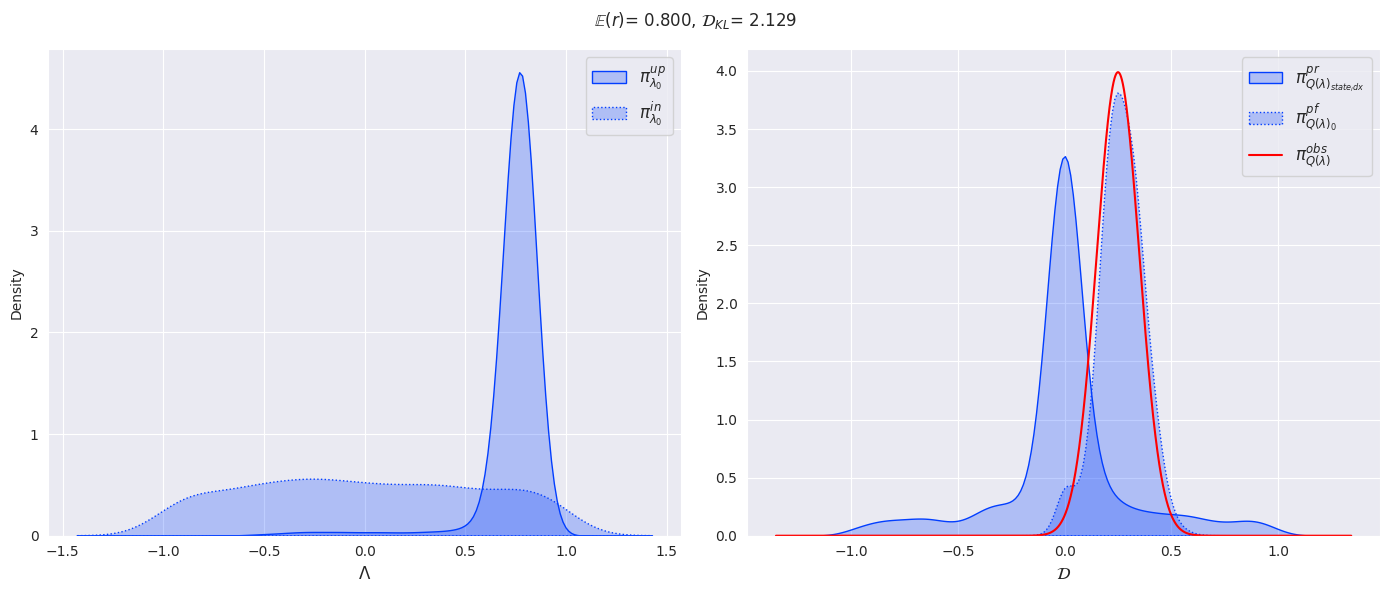

In [5]:
_ = d_prob.density_plots()

## Other Plots

Note we can use `pandas` default plotting capabilities to analyze the state dataframe quickly.

<Axes: >

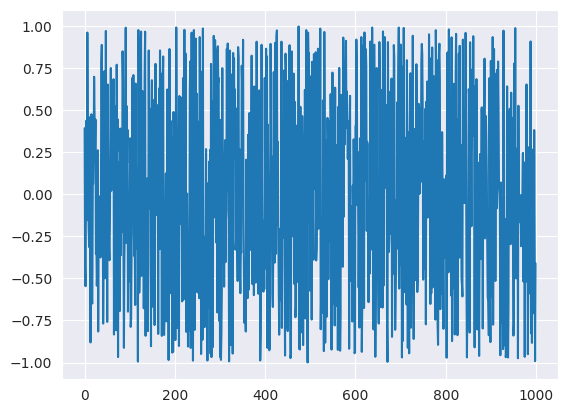

In [6]:
d_prob.state['lam_0'].plot()

<Axes: >

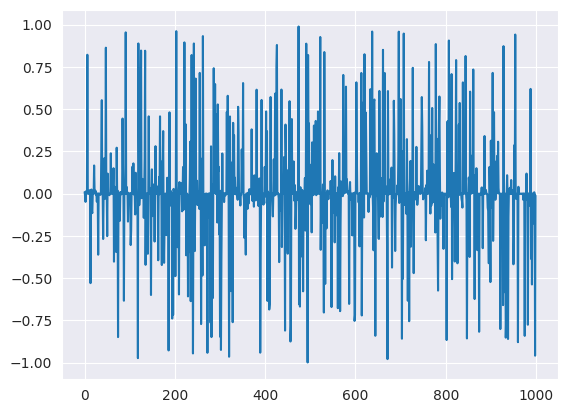

In [7]:
d_prob.state['q_lam_0'].plot()

## Explicitly Specifying `pi_in`

Note how in the case above, we knew that the initial samples came from a uniform distribution.
We could explicitly set it so that the pyDCI module doesn't have to do a kernel density estimate on the initial samples, making it run faster.

,e_r,kl
0,0.79988,2.128742


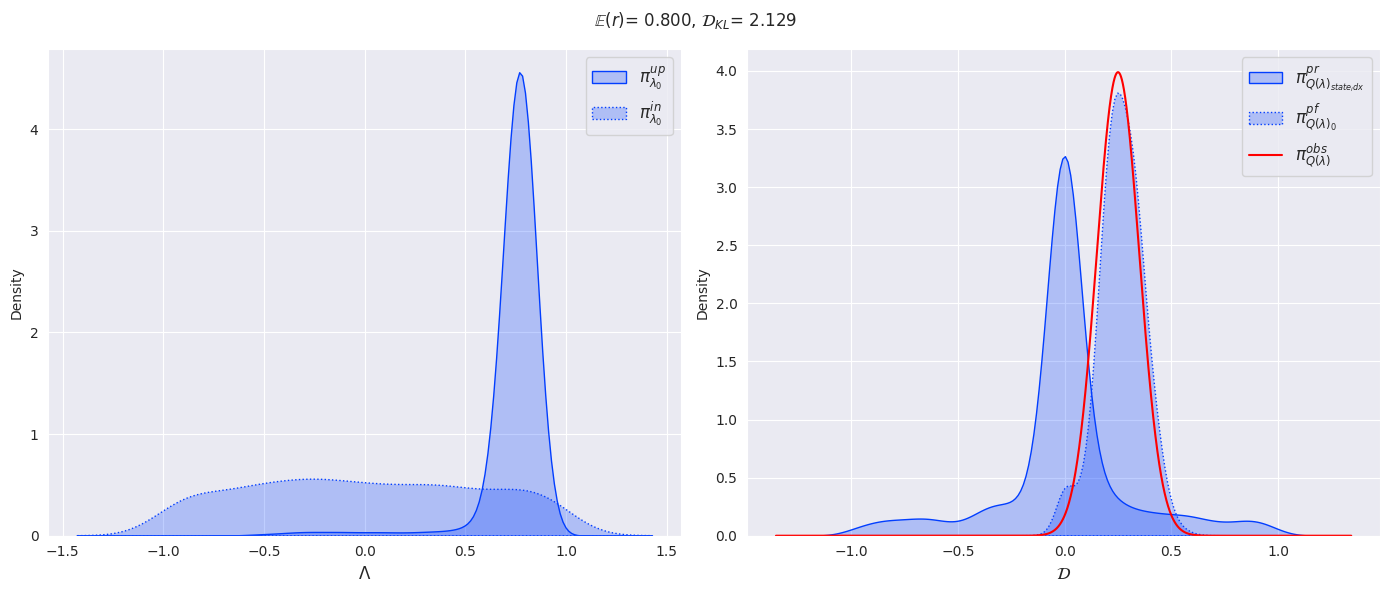

In [6]:
pi_in = uniform(loc=domain[0], scale=domain[1] - domain[0])
d_prob = DCIProblem((lam, q_lam), norm(data, scale=std_dev), pi_in=pi_in)
d_prob.solve()
_ = d_prob.density_plots()
d_prob.result

## Explicitly Setting `pi_pr`

What if we knew analytically `pi_pr`? 
Or We've computed some other way via another kernel density estimate call.
As long as the passed in form takes in a .pdf() method similar to scip.stats distributions, then they can be passed to the DCIProblem constructor.

For example, in the case when the exponent `p = 1` in the monomial example, we simply have the identity map.
Then the predicted distribution, would just be the initial distribution in this case, and we could set it explictly.

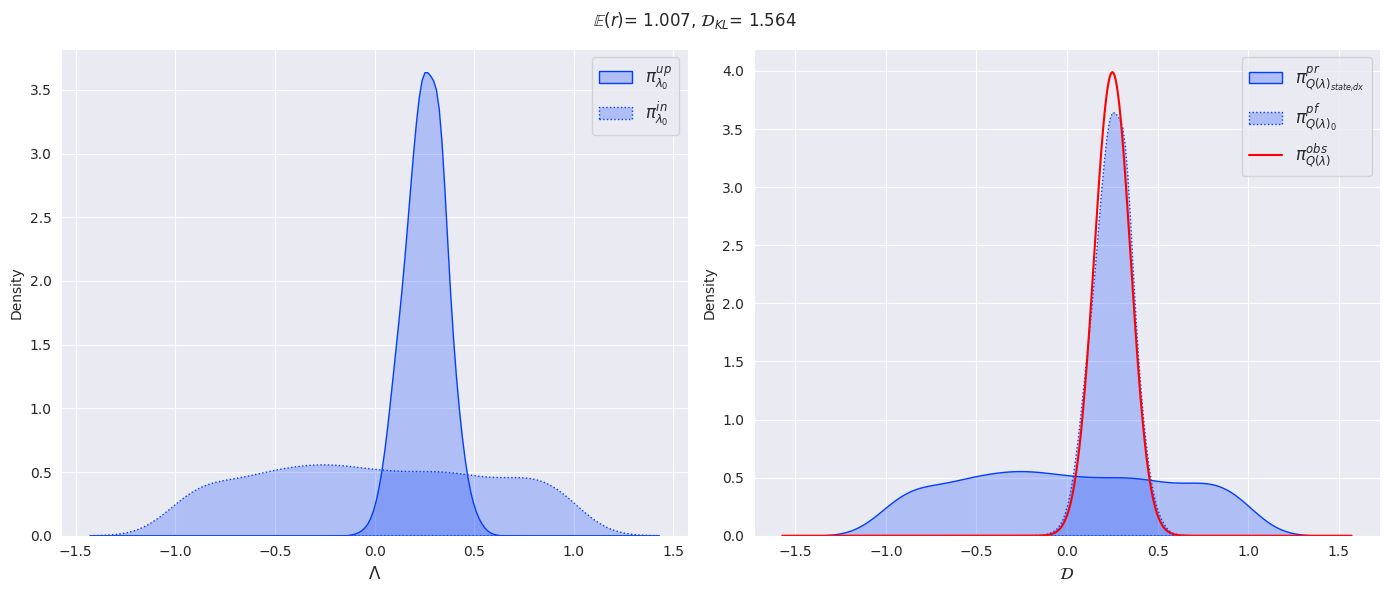

In [11]:
np.random.seed(123)

p, num_samples, data, sigma, domain = 1, int(1e3), [0.25], 0.1, [-1, 1]
lam = uniform.rvs(size=(num_samples, 1), loc=domain[0],
                  scale=domain[1] - domain[0])
q_lam = (lam**p).reshape(num_samples, -1)

pi_in = uniform(loc=domain[0], scale=domain[1] - domain[0])
d_prob = DCIProblem((lam, q_lam), norm(data, scale=sigma), pi_in=pi_in, pi_pr=pi_in)
d_prob.solve()
_ = d_prob.density_plots()

# Parameter Estimation

TODO: Blurb here about parameter estimation, relation to stochastic inverse problems, the MUD point etc.

## MUD Class

In [7]:
from pydci import MUDProblem

mud_prob = MUDProblem((lam, q_lam), data, std_dev)
mud_prob.solve()
mud_prob.result

,e_r,kl,lam_MUD_0
0,0.79988,2.128742,0.779117


In [4]:
mud_prob.state

,weight,pi_in,pi_pr,pi_obs,ratio,pi_up,q_lam_0,lam_0
0,1.0,0.493169,3.242866,2.205669e-01,6.801605e-02,3.354339e-02,0.009367,0.392938
1,1.0,0.533752,3.228581,1.213003e-01,3.757078e-02,2.005347e-02,-0.014315,-0.427721
2,1.0,0.498293,2.794093,4.613651e-02,1.651216e-02,8.227898e-03,-0.048657,-0.546297
3,1.0,0.508300,3.267662,1.753329e-01,5.365699e-02,2.727386e-02,0.000011,0.102630
4,1.0,0.484622,3.199445,2.599441e-01,8.124662e-02,3.937393e-02,0.016294,0.438938
...,...,...,...,...,...,...,...,...
995,1.0,0.522151,3.158518,9.545637e-02,3.022189e-02,1.578038e-02,-0.023230,-0.471205
996,1.0,0.494884,3.248465,2.140081e-01,6.587977e-02,3.260285e-02,0.008116,0.381831
997,1.0,0.554388,3.267435,1.639058e-01,5.016346e-02,2.781000e-02,-0.002670,-0.305708
998,1.0,0.254334,0.079769,7.255706e-32,9.095888e-31,2.313394e-31,-0.959004,-0.991663


array([<Axes: xlabel='$\\Lambda$', ylabel='Density'>,
       <Axes: xlabel='$\\mathcal{D}$', ylabel='Density'>], dtype=object)

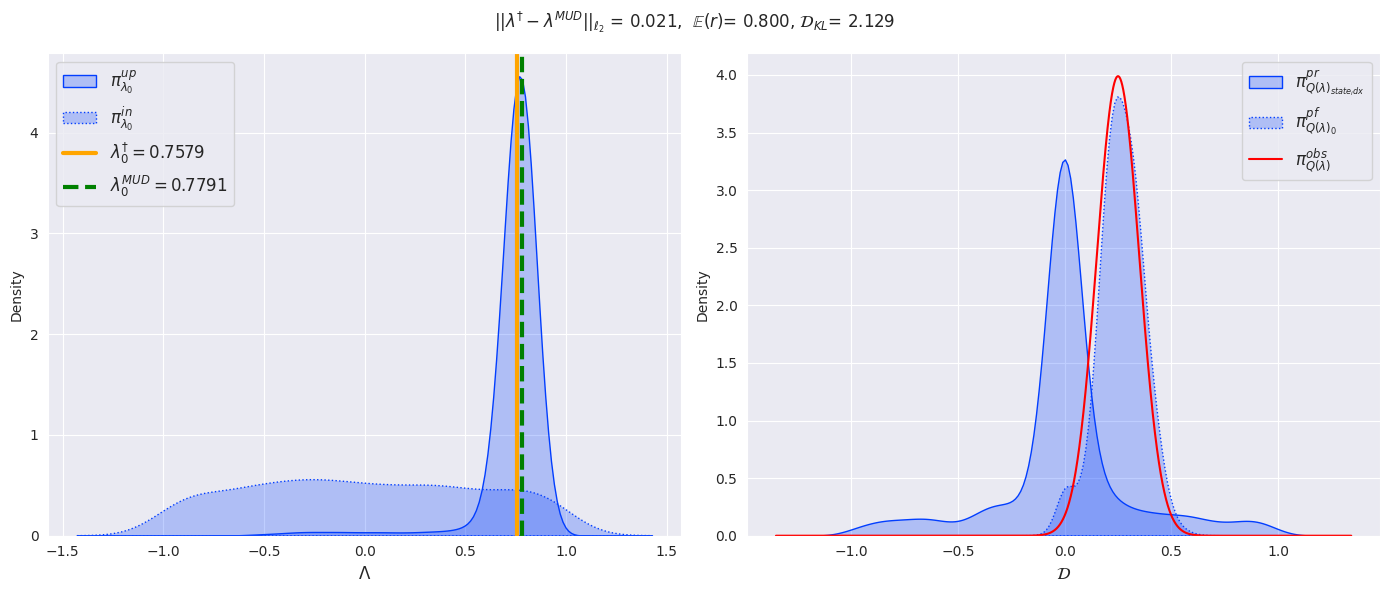

In [5]:
mud_prob.density_plots(lam_kwargs={'lam_true': [[0.25**0.2]]})

## Data Constructed Maps - PCAMUDProblem Class

TODO: Blurb here about Data-Constructed Maps

In [3]:
import pydci as dci
import importlib
importlib.reload(dci)

pca_prob = dci.PCAMUDProblem((lam, q_lam), data, std_dev)
pca_prob.solve()
pca_prob.result

,e_r,kl,lam_MUD_0,predict_delta,within_thresh,closest,max_kl,min_kl
nc,,,,,,,,
1,0.79988,2.128742,0.779117,0.20012,True,True,True,True


array([<Axes: xlabel='$\\Lambda$', ylabel='Density'>,
       <Axes: xlabel='$\\mathcal{D}$', ylabel='Density'>], dtype=object)

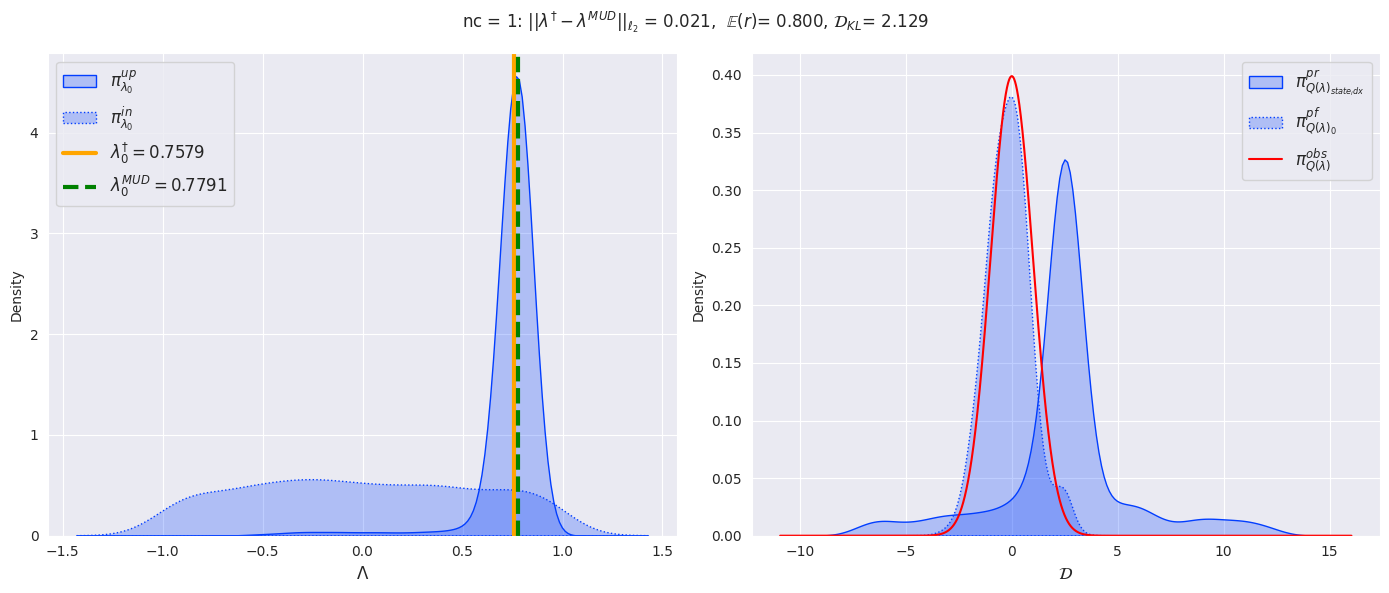

In [4]:
pca_prob.density_plots(lam_kwargs={'lam_true': [[0.25**0.2]]})

### Aggregating More Data

TODO: Fix/Update these sections:

Lets increase the number of data points we use.
We can see how with the $Q_{PCA}$ map we reduce the variance in the MUD estimate as more datapoints are used in the map.

In [16]:
N_vals = [1, 10, 100]

fig, ax = plt.subplots(len(N_vals), 2, figsize=(10, 5*len(N_vals)))
for i, N in enumerate(N_vals):
    qq_lam = (lam**p).reshape(num_samples, -1)
data = np.array([0.25])
    pca_prob = PCAMUDProblem.PCAMUDProblem(lam, q_lam, data, sigma)
    pca_prob.solve()
    _ = pca_prob.plot_param_state(true_vals=[[0.25**0.2]], ax=ax[i][0])
    _ = pca_prob.plot_obs_state(ax=ax[i][1])
    print(pca_prob.result)

IndentationError: unexpected indent (1336217209.py, line 7)

### Masking data used

Can use the mask argument to control what data we use in aggregating for the p

In [26]:
# Number of samples to use, and assumed observed normal distribution parameters
p, num_samples, mu, sigma, domain = 5, int(1e3), 0.25, 0.1, [-1, 1]
lam, q_lam, data = monomial(
    p=p,
    num_samples=num_samples,
    domain=domain,
    mu=mu,
    sigma=sigma,
    N=100)
lam.shape, q_lam.shape, data.shape

((1000, 1), (1000, 100), (100,))

[04/07/23 00:50:13] INFO     Adding q_lam of size 100 to dataframe                                     ]8;id=758305;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/utils.py\utils.py]8;;\:]8;id=425554;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/utils.py#147\147]8;;\

                    INFO     Adding lam of size 1 to dataframe                                         ]8;id=544796;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/utils.py\utils.py]8;;\:]8;id=285802;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/utils.py#147\147]8;;\

                    INFO     Adding q_pca of size 1 to dataframe                                       ]8;id=844584;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/utils.py\utils.py]8;;\:]8;id=208876;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/utils.py#147\147]8;;\

                    INFO     Adding lam_MUD of size 1 to dataframe                                     ]8;id=697358;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/utils.py\utils.py]8;;\:]8;id=182516;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/utils.py#147\147]8;;\

                    INFO     Adding lam_MUD of size 1 to dataframe                                     ]8;id=419214;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/utils.py\utils.py]8;;\:]8;id=377563;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/utils.py#147\147]8;;\

        e_r        kl  lam_MUD_0
0  0.914972  4.807961    0.76292


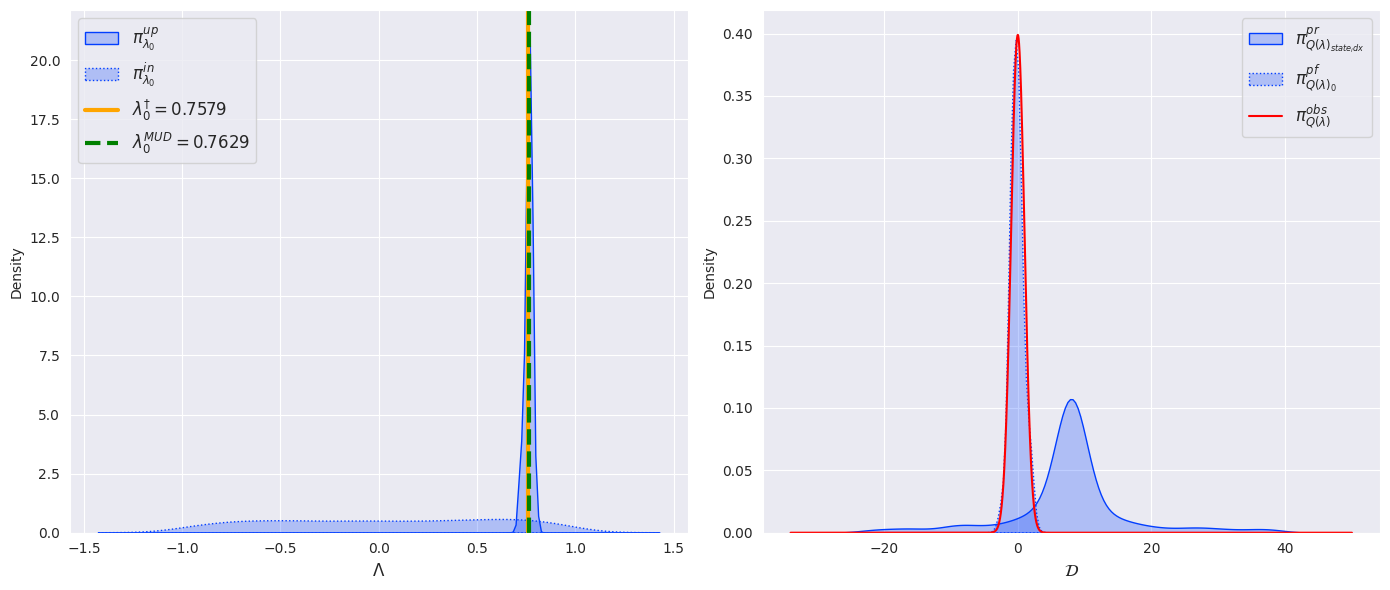

In [28]:
pca_prob = PCAMUDProblem.PCAMUDProblem(lam, q_lam, data, sigma)
pca_prob.pca_mask = range(10)
pca_prob.solve()
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
_, _ = pca_prob.plot_param_state(ax=axs[0], true_vals=[[0.25**0.2]]), pca_prob.plot_obs_state(ax=axs[1])
print(pca_prob.result)

# Sequential Estimation

When to split intervals up for parameter estimation -> Want to split up into intervals of quasi-linear dynamics.

In [3]:
from pydci import SplitSequentialProblem

split_prob = SplitSequentialProblem((lam, q_lam), data, std_dev)
split_prob.solve()
split_prob.result

,,,e_r,kl,lam_MUD_0,predict_delta,within_thresh,closest,max_kl,min_kl
split,nc,qoi_comb,,,,,,,,
0,1,0,0.79988,2.128742,0.779117,0.20012,True,True,True,True


In [4]:
split_prob.mud_arg

952

array([<Axes: xlabel='$\\Lambda$', ylabel='Density'>,
       <Axes: xlabel='$\\mathcal{D}$', ylabel='Density'>], dtype=object)

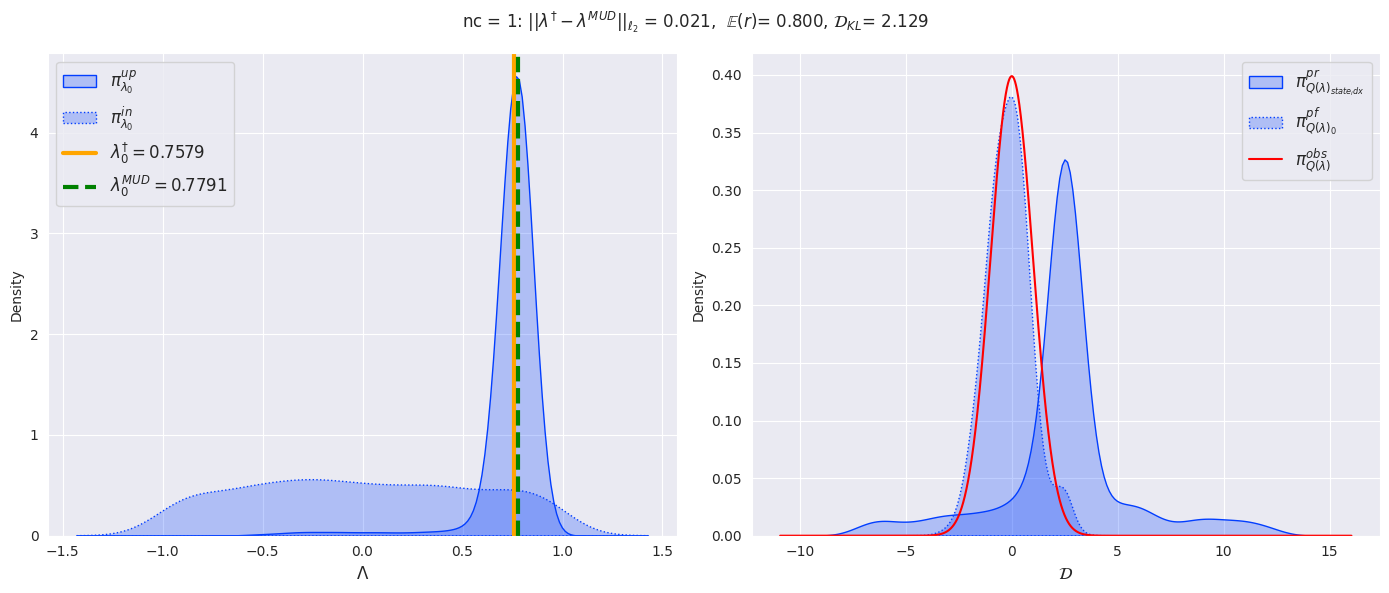

In [4]:
pca_prob.density_plots(lam_kwargs={'lam_true': [[0.25**0.2]]})